In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from model import PINN

In [2]:
data1 = pd.read_csv("data/astrometry_NACO.csv")
data2 = pd.read_csv("data/astrometry_SHARP.csv")


In [3]:
micro_arcsec_to_au = 3.14159265 / (3600*180) * 8 * 1000 * 206265 

x1 = data1.iloc[:,1].values * micro_arcsec_to_au 
y1 = data1.iloc[:,3].values * micro_arcsec_to_au

x2 = data2.iloc[:,1].values * micro_arcsec_to_au
y2 = data2.iloc[:,3].values * micro_arcsec_to_au

# X values
phi1 = np.arctan(y1/x1)
phi2 = np.arctan(y2/x2)
phi = torch.cat((torch.tensor(phi1, dtype=torch.float32), torch.tensor(phi2, dtype=torch.float32))).unsqueeze(1)

phi += (torch.randint(low=0,high=3,size=phi.shape) - 1) * 2 * torch.pi


# Y values
u1 = 1/np.sqrt(x1**2 + y1**2)
u2 = 1/np.sqrt(x2**2 + y2**2)
u = torch.cat((torch.tensor(u1, dtype=torch.float32), torch.tensor(u2, dtype=torch.float32))).unsqueeze(1)

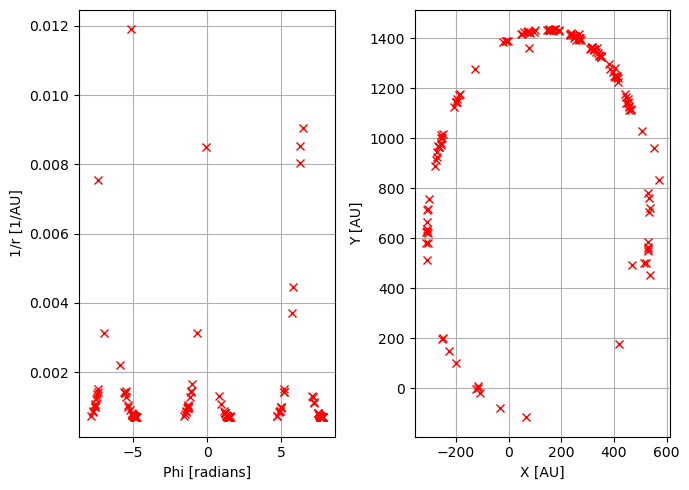

In [4]:
fig, ax = plt.subplots(figsize=(7,5), ncols=2)
#ax.set_xscale("log")

ax[0].plot(phi, u, 'rx')
ax[0].set_ylabel("1/r [1/AU]")
ax[0].set_xlabel("Phi [radians]")

ax[1].plot(x1, y1, 'rx')
ax[1].plot(x2, y2, 'rx')
ax[1].set_ylabel("Y [AU]")
ax[1].set_xlabel("X [AU]")

[axi.grid() for axi in ax]

plt.tight_layout()

In [5]:
# Initialize model
lr = 1e-4
phys_loss_weight = 1.

model = PINN(1, 1)
optimizer = optim.Adam(lr=lr, params=model.parameters())
criterion = nn.MSELoss()

losses = [[], [], []]

In [ ]:
epochs = 30000

for epoch in tqdm(range(epochs)):
    out = model(phi)

    MSEloss = criterion(out, u)


    PHYSloss = model.physical_loss()
    loss = MSEloss + phys_loss_weight * PHYSloss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[0].append(loss.detach().numpy())
    losses[1].append(MSEloss.detach().numpy())
    losses[2].append(PHYSloss.detach().numpy())

    

100%|██████████| 10000/10000 [02:14<00:00, 74.24it/s]


e = 1.3902854919433594
p = 6.296730570610662
M = 0.6828484535217285
mu = 0.10844492167234421


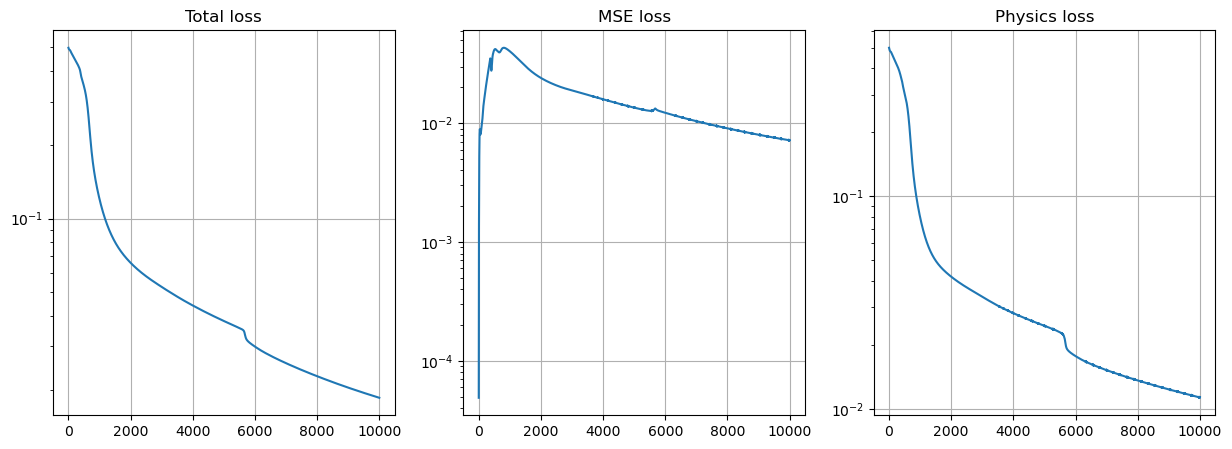

In [7]:
print("e =", model.e.item())
print("p =", model.M.item()/model.mu.item())
print("M =", model.M.item())
print("mu =", model.mu.item())

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(losses[0])
ax[0].set_title("Total loss")
ax[0].set_yscale("log")
ax[0].grid()

ax[1].plot(losses[1])
ax[1].set_title("MSE loss")
ax[1].set_yscale("log")
ax[1].grid()

ax[2].plot(losses[2])
ax[2].set_title("Physics loss")
ax[2].set_yscale("log")
ax[2].grid()

plt.show()

#        self.e = torch.nn.Parameter(torch.tensor(0.8))
#        self.p = torch.nn.Parameter(torch.tensor(220.))
#        self.M = torch.nn.Parameter(torch.tensor(.04))
# mu ~ 1.8e-4


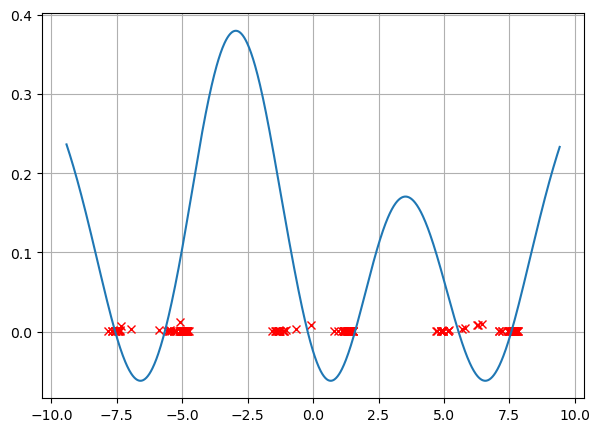

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ax.grid()
#ax.set_xscale("log")

ax.plot(phi, u, 'rx')

x_ = torch.linspace(-3*3.1415, 3*3.1415, steps=1000, dtype=torch.float32)
y = model(x_.unsqueeze(1)).detach().numpy()
ax.plot(x_, y)